<a href="https://colab.research.google.com/github/nascimento-luciano/Artificial-Intelligence/blob/master/Analise_COVID_19_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
#---------------------------------Etapa 1--------------------------------------
#Importanto bibliotecas

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#import geopandas as gpd -----> Verificar porque não carrega a biblioteca
import plotly.express as px
import plotly.graph_objects as go

In [100]:
#Importação da biblioteca geopandas via instalação no Colab
!pip install geopandas

In [101]:
#---------------------------------Etapa 2--------------------------------------
#Importando Arquivo CSV
#Dados não "Oficiais"
covid_cases = pd.read_csv('worldometer_coronavirus_daily_data.csv')
covid_vaxxs = pd.read_csv('country_vaccinations.csv')
df = pd.read_csv('covid_19_data.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sub=pd.read_csv('submission.csv')
submission=pd.read_csv('submission.csv')
confirmed_df = pd.read_csv('time_series_covid_19_confirmed.csv')

#train['Date'] = pd.to_datetime(train['Date'])
#test['Date'] = pd.to_datetime(test['Date'])


In [102]:
#---------------------------------Etapa 3--------------------------------------
#Vamos marcar o datase e usar como amostra o Brazil

def fix_country_name(country):
    name_dict = {
        'BRA': 'Brazil'
     }
    try:
      return name_dict[country]
    except KeyError:
      return country

covid_cases.country = covid_cases.country.apply(fix_country_name)

In [103]:
#---------------------------------Etapa 4--------------------------------------
#Vamos observar o caso do Brasil
countries_of_interest = ["Brazil"]

#Vamos começar a limpar os dados filtrando-o para o subconjunto de países que desejamos.
covid_cases_subset = covid_cases[covid_cases.country.isin (countries_of_interest)]
covid_vaxxs_subset = covid_vaxxs[covid_vaxxs.country.isin (countries_of_interest)]

In [104]:
#---------------------------------Etapa 5--------------------------------------
#Unindo os databases usando as datas e países
   
merged_data = pd.merge_ordered(covid_cases_subset, covid_vaxxs_subset, \
                               left_on=['date', 'country'], \
                               right_on=['date', 'country'])

#Remove as colunas desnecessárias
merged_data.drop(columns=['iso_code', 'source_name', 'source_website', 'vaccines',\
                           'daily_vaccinations_per_million', 'daily_vaccinations_raw'], inplace=True)

In [105]:
#---------------------------------Etapa 6--------------------------------------
#Vamos lidar com os NaNs
merged_data.fillna({'total_vaccinations':0, 'people_vaccinated':0, 'people_fully_vaccinated':0,\
                 'daily_vaccinations':0,'total_vaccinations_per_hundred':0,\
                 'people_vaccinated_per_hundred':0 ,'people_fully_vaccinated_per_hundred':0}\
                 ,inplace=True)

covid_data = merged_data.dropna(how='any', subset=['cumulative_total_cases'])

In [106]:
#---------------------------------Etapa 7--------------------------------------
#Vamos também definir o índice para a data
covid_data.set_index('date', inplace=True)

In [107]:
#Vamos mudar o índice para um objeto datetime agora
covid_data.index = pd.to_datetime(covid_data.index, errors='coerce', infer_datetime_format=True)

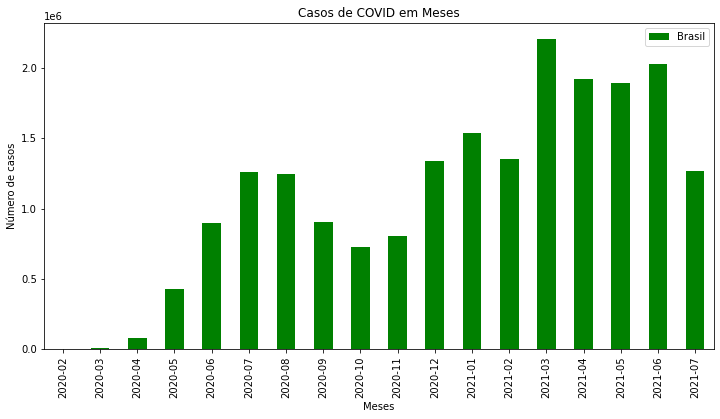

In [142]:
#---------------------------------Etapa 10--------------------------------------
#A época do ano é importante para infecções?
BRA_infections = covid_data[covid_data.country == 'Brazil']

plt.figure(figsize=(12, 6))
BRA_infections['daily_new_cases']\
  .groupby(BRA_infections.index.to_period('M'))\
  .sum().plot(kind='bar', legend=False, color='g')

plt.legend(['Brasil'])
plt.ylabel('Número de casos')
plt.xlabel('Meses')
plt.title('Casos de COVID em Meses');

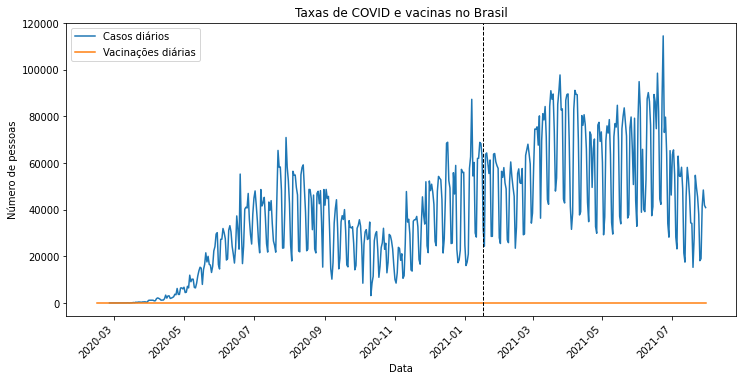

In [109]:
#---------------------------------Etapa 11--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Brazil'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Brazil'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina  -----> Mônica Calazans (Primeiro Vacinado)
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Brasil');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil
#https://ourworldindata.org/coronavirus/country/brazil

--------------------------Fim do Código---------------------------------------

2ª Parte - Plotagem do Modelo de Predição de Casos de Confirmados no Brasil

In [110]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import bokeh 
from bokeh.io import output_notebook
from bokeh.resources import INLINE
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
output_notebook(resources=INLINE)
%matplotlib inline

In [111]:
#!pip install MinMaxScaler

In [112]:
train = pd.DataFrame(pd.read_csv('train.csv'))

In [113]:
print("The shape of training data is = {}".format(train.shape))

The shape of training data is = (35995, 6)


In [114]:
train.Province_State.fillna("", inplace = True)
train.ConfirmedCases.fillna("", inplace = True)
train.Fatalities.fillna("", inplace = True)

In [115]:
train["Country_Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [116]:
confirmed_cases_brazil = train[train["Country_Region"] == "Brazil"].groupby(["Date"]).ConfirmedCases.sum()
fatal_cases_brazil = train[train["Country_Region"] == "Brazil"].groupby(["Date"]).Fatalities.sum()

In [117]:
train_brazil = train[train["Country_Region"] == "Brazil"]
train_brazil

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
3450,3451,,Brazil,2020-01-22,0.0,0.0
3451,3452,,Brazil,2020-01-23,0.0,0.0
3452,3453,,Brazil,2020-01-24,0.0,0.0
3453,3454,,Brazil,2020-01-25,0.0,0.0
3454,3455,,Brazil,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
3560,3561,,Brazil,2020-05-11,169594.0,11653.0
3561,3562,,Brazil,2020-05-12,178214.0,12461.0
3562,3563,,Brazil,2020-05-13,190137.0,13240.0
3563,3564,,Brazil,2020-05-14,203165.0,13999.0


In [118]:
train_brazil["ConfirmedCases"] = train_brazil["ConfirmedCases"].astype(int)
train_brazil["Fatalities"] = train_brazil["Fatalities"].astype(int)

In [119]:
train_brazil_size = int(len(train_brazil) * 0.75)
val_brazil_size = len(train_brazil) - train_brazil_size
print("Training size = {}".format(train_brazil_size))
print("Validation size = {}".format(val_brazil_size))

Training size = 86
Validation size = 29


In [120]:
train_brazil_confirmed_cases = train_brazil[["ConfirmedCases"]]
train_brazil_fatal_cases = train_brazil[["Fatalities"]]

In [121]:
print(train_brazil_confirmed_cases, train_brazil_fatal_cases)

      ConfirmedCases
3450               0
3451               0
3452               0
3453               0
3454               0
...              ...
3560          169594
3561          178214
3562          190137
3563          203165
3564          220291

[115 rows x 1 columns]       Fatalities
3450           0
3451           0
3452           0
3453           0
3454           0
...          ...
3560       11653
3561       12461
3562       13240
3563       13999
3564       14962

[115 rows x 1 columns]


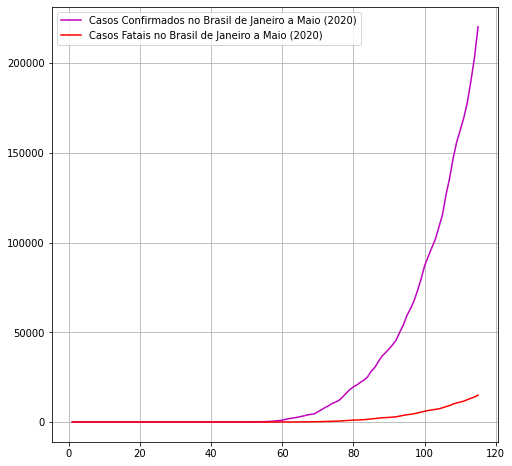

In [122]:
plt.figure(figsize = (8, 8))
x = np.arange(1, 116, 1)
y1 = train_brazil_confirmed_cases 
y2 = train_brazil_fatal_cases 
plt.plot(x, y1, color = "m", label = "Casos Confirmados no Brasil de Janeiro a Maio (2020)")
plt.plot(x, y2, color = "r", label = "Casos Fatais no Brasil de Janeiro a Maio (2020)")
plt.grid(True)
plt.legend()

In [123]:
len(train_brazil_confirmed_cases)

115

In [124]:
train_brazil_confirmed_cases

,ConfirmedCases
3450,0
3451,0
3452,0
3453,0
3454,0
...,...
3560,169594
3561,178214
3562,190137
3563,203165


In [125]:
train_brazil_confirmed_cases_data = train_brazil_confirmed_cases.iloc[0:train_brazil_size]
val_brazil_confirmed_cases_data = train_brazil_confirmed_cases.iloc[train_brazil_size : len(train_brazil_confirmed_cases)]

In [126]:
print(len(train_brazil_confirmed_cases_data))
print(len(val_brazil_confirmed_cases_data))

86
29


In [127]:
scaler = MinMaxScaler(feature_range = (0,1))
def createDataset(train) : 
    train_scaled = scaler.fit_transform(train)
    x_train = [] 
    y_train = []
    time_step = 2
    for i in range(time_step, train_scaled.shape[0]):
        x_train.append(train_scaled[i-time_step : i , 0])
        y_train.append(train_scaled[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
    y_train = np.reshape(y_train, (y_train.shape[0], 1 ))
    return x_train, y_train     

In [128]:
def createDataset(train) : 
    train_scaled = scaler.fit_transform(train)
    x_train = [] 
    y_train = []
    time_step = 2
    for i in range(time_step, train_scaled.shape[0]):
        x_train.append(train_scaled[i-time_step : i , 0])
        y_train.append(train_scaled[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
    y_train = np.reshape(y_train, (y_train.shape[0], 1 ))
    return x_train, y_train   

In [129]:
x_train, y_train = createDataset(train_brazil_confirmed_cases_data)
x_val, y_val = createDataset(val_brazil_confirmed_cases_data)

In [130]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(84, 2, 1) (84, 1)
(27, 2, 1) (27, 1)


In [131]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units = 1))

In [132]:
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

In [133]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 50)             10400     
                                                                 
 dropout_8 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 2, 50)             20200     
                                                                 
 dropout_9 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_10 (LSTM)              (None, 2, 50)             20200     
                                                                 
 dropout_10 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [134]:
EPOCHS = 200
BATCH_SIZE = 1

In [135]:
with tf.device("/device:GPU:0"):
  history = model.fit(x_train, y_train,epochs = EPOCHS, verbose = 1,
                     batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/200
84/84 [==============================] - 7s 25ms/step - loss: 0.0626 - val_loss: 0.1411
Epoch 2/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0359 - val_loss: 0.0095
Epoch 3/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 4/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 5/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0160
Epoch 6/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0159
Epoch 7/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0213
Epoch 8/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0088
Epoch 9/200
84/84 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 10/200
84/84 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11

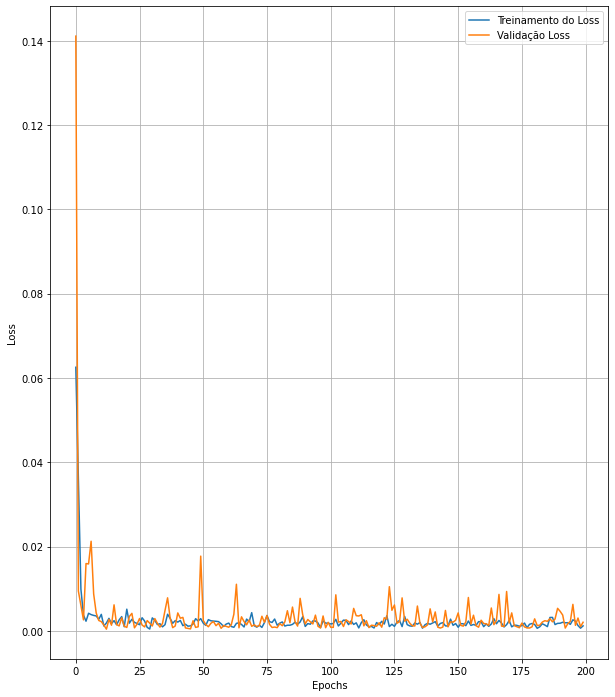

In [136]:
x = np.arange(0, EPOCHS, 1)                                                                  
plt.figure(1, figsize = (22, 12))                                  
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, history.history["loss"], label = "Treinamento do Loss")
plt.plot(x, history.history["val_loss"], label = "Validação Loss")
plt.grid(True)
plt.legend()  

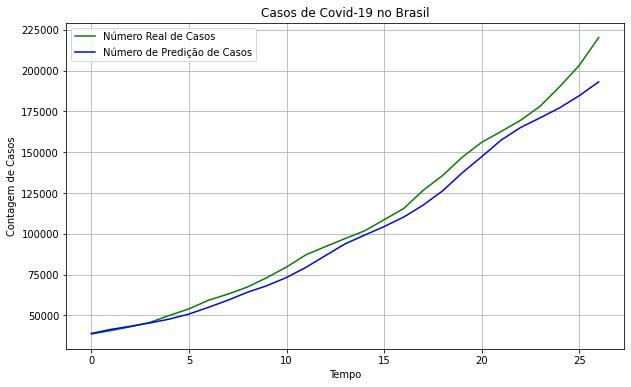

In [141]:
predicted_cases = model.predict(x_val)
predicted_cases = scaler.inverse_transform(predicted_cases)
real_cases = scaler.inverse_transform(y_val)
plt.figure(figsize= (10, 6))
plt.subplot(1,1,1)
plt.plot(real_cases, color = "green", label = "Número Real de Casos")
plt.plot(predicted_cases, color = "blue", label = "Número de Predição de Casos")
plt.title("Casos de Covid-19 no Brasil")
plt.xlabel("Tempo")
plt.ylabel("Contagem de Casos")
plt.legend()
plt.grid("both")
plt.show()